# **CV Project**

In [1]:
!pip install gdown librosa tensorflow matplotlib scikit-learn opencv-python seaborn

from google.colab import drive
drive.mount('/content/drive')

import os
import gdown
import zipfile
import shutil




Mounted at /content/drive


In [2]:

DRIVE_FILE_ID = "1Oxbcp06EaSfctkHM--SGJQzHFfFO4nmG"
ZIP_FILE = "machine_faults_dataset.zip"
DATA_DIR = "machine_faults"
FAULT_LABELS = ["Arcing", "Corona", "Looseness", "Tracking"]

download_link = f"https://drive.google.com/uc?id={DRIVE_FILE_ID}"
print("[INFO] Downloading dataset...")
gdown.download(download_link, ZIP_FILE, quiet=False)




[INFO] Downloading dataset...


Downloading...
From (original): https://drive.google.com/uc?id=1Oxbcp06EaSfctkHM--SGJQzHFfFO4nmG
From (redirected): https://drive.google.com/uc?id=1Oxbcp06EaSfctkHM--SGJQzHFfFO4nmG&confirm=t&uuid=dc50d966-a70a-4e23-81ea-66a66251a132
To: /content/machine_faults_dataset.zip
100%|██████████| 48.0M/48.0M [00:00<00:00, 72.6MB/s]


'machine_faults_dataset.zip'

In [3]:
print("[INFO] Extracting dataset files...")
with zipfile.ZipFile(ZIP_FILE, 'r') as z:
    z.extractall(DATA_DIR)


for label in FAULT_LABELS:
    os.makedirs(os.path.join(DATA_DIR, label), exist_ok=True)

for root, _, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith(('.wav', '.mp3', '.flac')):
            lower_fname = fname.lower()
            assigned_label = None
            for label in FAULT_LABELS:
                if label.lower() in lower_fname:
                    assigned_label = label
                    break
            if assigned_label:
                source_path = os.path.join(root, fname)
                dest_path = os.path.join(DATA_DIR, assigned_label, fname)
                if not os.path.exists(dest_path):
                    shutil.move(source_path, dest_path)
print("Dataset is organized.")



[INFO] Extracting dataset files...
Dataset is organized.


In [4]:
import librosa
import numpy as np
import cv2


SEGMENT_SEC = 0.4
OVERLAP_RATIO = 0.2
NUM_COEFF = 13
FFT_SIZE = 2048
HOP_SIZE = 512
TARGET_DIMS = (64, 64)

def segment_signal(signal, sr, duration=SEGMENT_SEC, overlap=OVERLAP_RATIO):
    seg_len = int(duration * sr)
    step = int(seg_len * (1 - overlap))
    segments = [signal[i:i+seg_len] for i in range(0, len(signal) - seg_len + 1, step)]
    return segments

def process_segment(segment, sr):
    mfcc_matrix = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=NUM_COEFF)
    stft_result = librosa.stft(segment, n_fft=FFT_SIZE, hop_length=HOP_SIZE)
    mag_matrix = librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)
    phase_matrix = np.angle(stft_result)
    mfcc_img = cv2.resize(mfcc_matrix, TARGET_DIMS)
    mag_img = cv2.resize(mag_matrix, TARGET_DIMS)
    phase_img = cv2.resize(phase_matrix, TARGET_DIMS)
    return np.stack([mfcc_img, mag_img, phase_img], axis=-1)

def extract_audio_features(signal, sr):
    segs = segment_signal(signal, sr)
    return [process_segment(seg, sr) for seg in segs]


def augment_signal(audio, sr):
    augmented = []
    try:
        augmented.append(librosa.effects.time_stretch(audio, rate=1.1))
        augmented.append(librosa.effects.time_stretch(audio, rate=0.9))
    except Exception as err:
        print("Time stretching error:", err)
    try:
        augmented.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=2))
        augmented.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=-2))
    except Exception as err:
        print("Pitch shifting error:", err)
    noise = np.random.normal(0, 0.005, size=audio.shape)
    augmented.append(audio + noise)
    return augmented


feature_data = []
feature_labels = []

for label in FAULT_LABELS:
    label_dir = os.path.join(DATA_DIR, label)
    for fname in os.listdir(label_dir):
        if fname.lower().endswith(('.wav', '.mp3', '.flac')):
            file_path = os.path.join(label_dir, fname)
            try:
                audio_data, sample_rate = librosa.load(file_path, sr=None)
            except Exception as ex:
                print(f"Error loading {file_path}: {ex}")
                continue
            orig_features = extract_audio_features(audio_data, sample_rate)
            feature_data.extend(orig_features)
            feature_labels.extend([label] * len(orig_features))

            for aug_audio in augment_signal(audio_data, sample_rate):
                aug_features = extract_audio_features(aug_audio, sample_rate)
                feature_data.extend(aug_features)
                feature_labels.extend([label] * len(aug_features))

features_arr = np.array(feature_data)
labels_arr = np.array(feature_labels)
print("Feature array shape:", features_arr.shape)


norm_features = np.empty_like(features_arr, dtype=np.float32)
for ch in range(features_arr.shape[-1]):
    channel_data = features_arr[..., ch]
    mean_val = np.mean(channel_data)
    std_val = np.std(channel_data) if np.std(channel_data) > 0 else 1.0
    norm_features[..., ch] = (channel_data - mean_val) / std_val



Feature array shape: (11257, 64, 64, 3)


Image counts per class:
Arcing: 2193
Corona: 2716
Looseness: 3137
Tracking: 3211


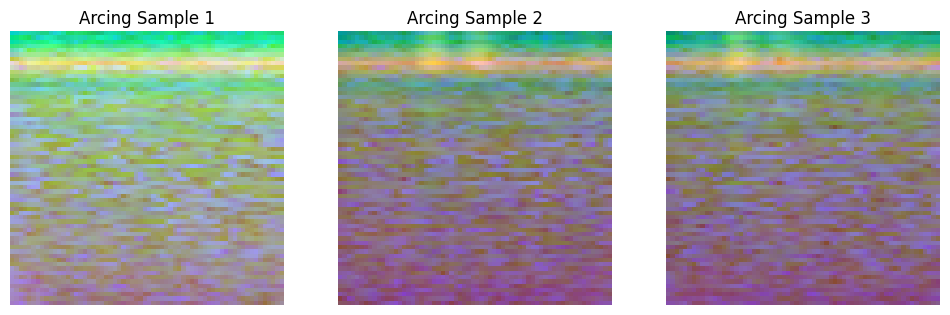

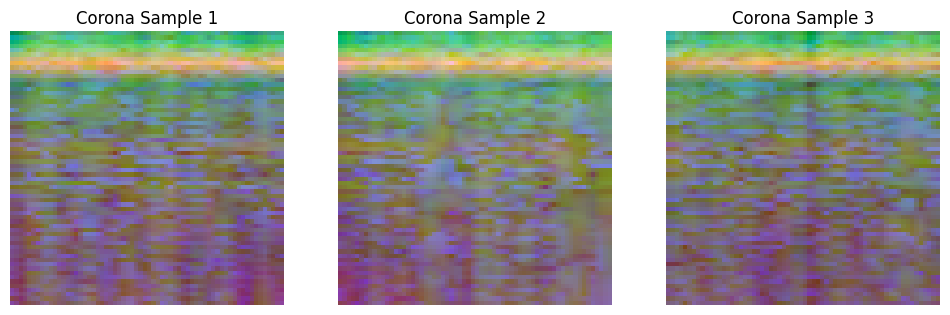

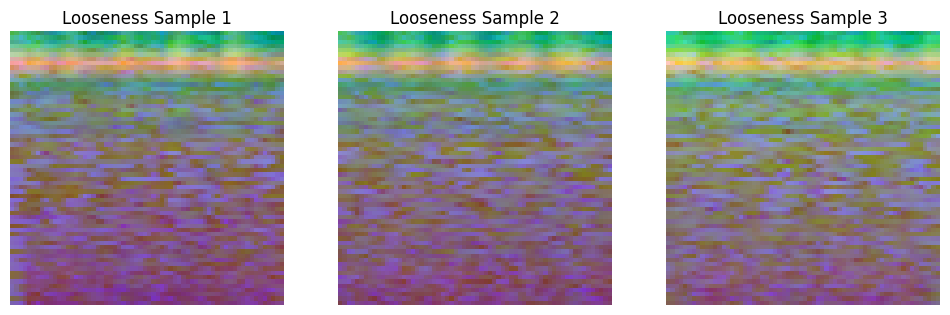

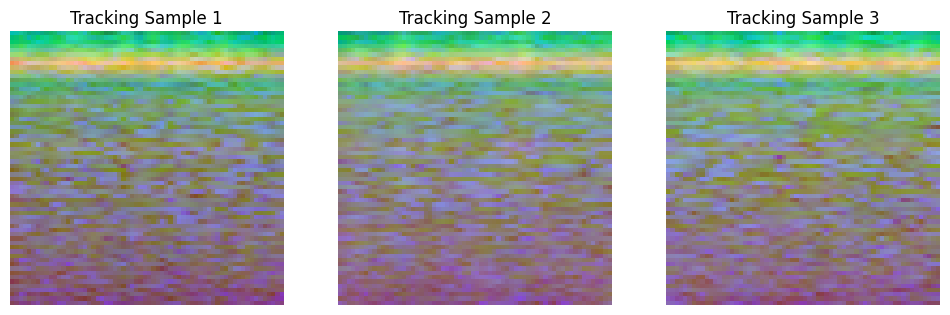

In [11]:
'''
import matplotlib.pyplot as plt

#save_dir = '/content/drive/MyDrive/CV_Project_feature_images'
save_dir = '/content/drive/MyDrive/CV_Project_feature_images'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(save_dir)

img_counts = {lab: 0 for lab in FAULT_LABELS}

for idx, (img, lab) in enumerate(zip(norm_features, labels_arr)):
    img_min, img_max = img.min(), img.max()
    img_scaled = ((img - img_min) / (img_max - img_min + 1e-8) * 255).astype(np.uint8)

    class_folder = os.path.join(save_dir, lab)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

    file_out = os.path.join(class_folder, f"{lab}_{img_counts[lab]}.png")
    cv2.imwrite(file_out, cv2.cvtColor(img_scaled, cv2.COLOR_RGB2BGR))
    img_counts[lab] += 1

print("Image counts per class:")
for lab in FAULT_LABELS:
    print(f"{lab}: {img_counts[lab]}")

for lab in FAULT_LABELS:
    class_folder = os.path.join(save_dir, lab)
    sample_files = os.listdir(class_folder)[:3]
    plt.figure(figsize=(12,4))
    for i, sfile in enumerate(sample_files):
        sample_path = os.path.join(class_folder, sfile)
        sample_img = cv2.imread(sample_path)
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(sample_img)
        plt.title(f"{lab} Sample {i+1}")
        plt.axis('off')
    plt.show()

'''



import matplotlib.pyplot as plt

# Define the save directory for feature images
save_dir = '/content/drive/MyDrive/CV_Project_feature_images'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
# os.makedirs(save_dir)  # This line is redundant and causes the FileExistsError

img_counts = {lab: 0 for lab in FAULT_LABELS}

for idx, (img, lab) in enumerate(zip(norm_features, labels_arr)):
    img_min, img_max = img.min(), img.max()
    img_scaled = ((img - img_min) / (img_max - img_min + 1e-8) * 255).astype(np.uint8)

    class_folder = os.path.join(save_dir, lab)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

    file_out = os.path.join(class_folder, f"{lab}_{img_counts[lab]}.png")
    cv2.imwrite(file_out, cv2.cvtColor(img_scaled, cv2.COLOR_RGB2BGR))
    img_counts[lab] += 1

print("Image counts per class:")
for lab in FAULT_LABELS:
    print(f"{lab}: {img_counts[lab]}")

for lab in FAULT_LABELS:
    class_folder = os.path.join(save_dir, lab)
    sample_files = os.listdir(class_folder)[:3]
    plt.figure(figsize=(12, 4))
    for i, sfile in enumerate(sample_files):
        sample_path = os.path.join(class_folder, sfile)
        sample_img = cv2.imread(sample_path)
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i+1)
        plt.imshow(sample_img)
        plt.title(f"{lab} Sample {i+1}")
        plt.axis('off')
    plt.show()



Train set shape: (7879, 64, 64, 3)
Validation set shape: (1689, 64, 64, 3)
Test set shape: (1689, 64, 64, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,668 (6.20 MB)

 Trainable params: 1,625,668 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3569 - loss: 1.4893 - val_accuracy: 0.5015 - val_loss: 1.1625
Epoch 2/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4606 - loss: 1.1483 - val_accuracy: 0.5867 - val_loss: 1.0153
Epoch 3/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5731 - loss: 1.0059 - val_accuracy: 0.6454 - val_loss: 0.8477
Epoch 4/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6291 - loss: 0.8855 - val_accuracy: 0.6963 - val_loss: 0.7557
Epoch 5/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6608 - loss: 0.8063 - val_accuracy: 0.6921 - val_loss: 0.7063
Epoch 6/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6864 - loss: 0.7494 - val_accuracy: 0.7460 - val_loss: 0.6360
Epoch 7/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7080 - loss: 0.7051 - val_accuracy: 0.7531 - val_loss: 0.6008
Epoch 8/35
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7141 - loss: 0.6807 - val_accuracy:

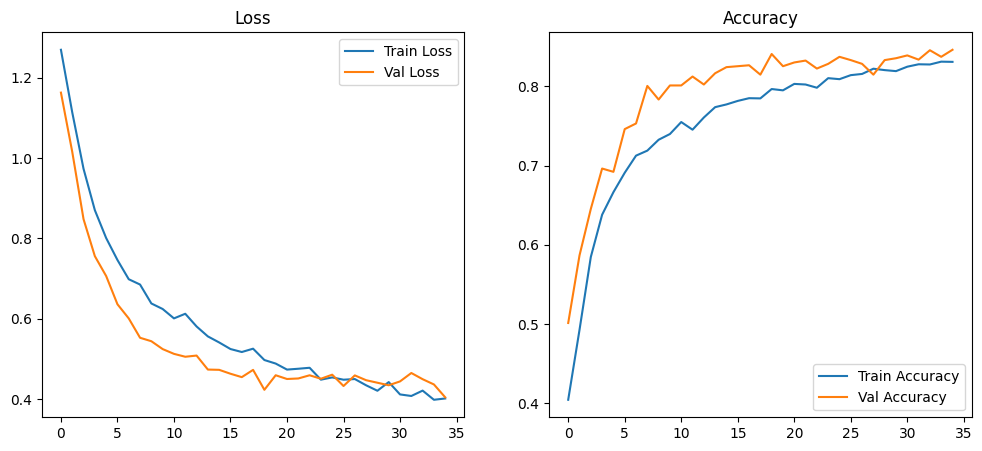

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.3990
Test Accuracy: 0.837773859500885
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


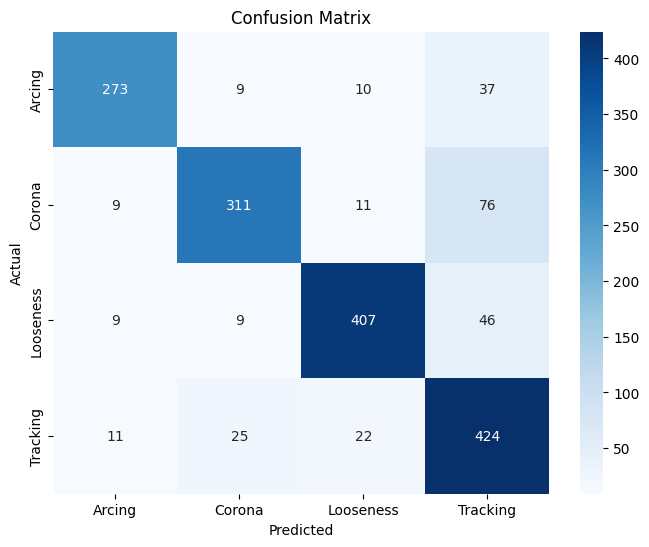

Model saved to: /content/drive/MyDrive/saved_models/fault_detection_model.h5


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Encode labels and perform one-hot encoding
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels_arr)
one_hot_labels = to_categorical(encoded_labels, num_classes=len(FAULT_LABELS))

# Split the data into training, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(
    norm_features, one_hot_labels, test_size=0.3, random_state=42, stratify=one_hot_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Define the CNN model
input_shape = X_train.shape[1:]
num_classes = len(FAULT_LABELS)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Define early stopping callback (optional)
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with positional arguments first, followed by keyword arguments
history = cnn_model.fit(
    X_train, y_train,  # Positional arguments
    verbose=1,
    epochs=35,
    batch_size=32,
    validation_data=(X_val, y_val)
    # callbacks=[stop_early]  # Uncomment if you wish to use early stopping
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Generate confusion matrix
y_pred_labels = np.argmax(cnn_model.predict(X_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=FAULT_LABELS, yticklabels=FAULT_LABELS, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model
MODEL_SAVE_PATH = '/content/drive/MyDrive/saved_models/fault_detection_model.h5'
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
cnn_model.save(MODEL_SAVE_PATH)
print("Model saved to:", MODEL_SAVE_PATH)
